### 統計學習與深度學習
### Homework 4

請將IPYNB檔上傳至COOL作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Multilayer Perceptrons for Regression
本次作業的主角是 Multilayer perceptrons (MLP)。我們將以MLP建構迴歸模型，探討各項相關議題。


#### Dataset: Million Songs Dataset
本次作業將使用"Million Songs Dataset"作為訓練與測試資料。請使用`pickle.load()`載入*msd_full.pickle*。這個資料集已經切割好了訓練與測試資料，並存放在一個Dictionary的結構。這個Dictionary有四個元素，x_train, y_train, x_test, y_test，分別對應到訓練特徵、訓練標記(Label)、測試特徵、測試標記。 標記變數 (label variable; i.e., $y$) 是歌曲發行年度。特徵為歌曲的聲音特性。迴歸任務為預測歌曲年分。

#### Prediction Performance and Loss Function
模型訓練應主要使用Sum of Squared Error (SSE)建構Loss Function，另外我們也會練習使用其他種類的Loss Function。為了讓圖表易於理解，不論Loss Function為何，報告預測能力應使用Root Mean Squared Error (RMSE)。使用SSE或RMSE建構Loss Function在本質上沒有差別。但SSE計算成本稍低，而RMSE較有直觀意義。


#### Subtraining, Validation, and Test Datasets
*msd_full.pickle* 檔案中的訓練資料已經隨機排序過。你應該使用訓練資料最後10%的資料做為Validation Set。其餘的前90%做為Subtraining Set。使用Subtraining Set來訓練資料，並以Validation Set作為參數調教與Early Stopping的依據。Test RMSE應使用測試資料計算得之。

所有特徵應該標準化(均數為零，變異數為一)。標準化應該以訓練資料(注意不是Test Set or Subtraining Set)的統計量為之。標記變數(i.e., $y$)應將均數平移至0 (依照訓練資料的統計量)。標記變數的變異數不要調整。


#### Minibatch, Epoch, and Early Stopping
如果沒有特別說明，模型訓練時應以大小為1,000個資料點的Minibatch為之。模型使用一個Minibatch的資料更新參數之後稱為經歷了一個Batch。當所有Subtraining資料已經用來更新過模型參數，稱為經過了一個Epoch。

模型訓練應使用Early Stopping決定最佳的模型。模型訓練時每100個Batch計算一次Training and Validation RMSE。如果Validation為歷史最低，則記下當下的模型參數與當時已進行的Batch數量，稱為best_step_count。如由best_step_count起算已經經過了5,000個Batch而沒有更好的Validation RMSE，則停止模型訓練，並以best_step_count時的模型參數做為最後的模型訓練結果。如果模型訓練最多執行100個epoch。如果模型已經執行了100個epoch而沒有Early Stop，則應使用歷史最佳的Validation RMSE所對應到的模型參數計算Test RMSE。


#### Implementation Restriction
使用Pytorch建構MLP模型。Ordinary Least Square (OLS)模型訓練沒有限制使用何種套件。

#### 資料載入
使用下面的程式碼載入資料:

In [1]:
#load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

#Load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    #standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


#validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


### 回答下面問題

#### Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

#### Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function之後進入下一個線性層與ReLu Activation Function。如此再重複兩次線性層與Activation的疊加之後，通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

#### Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

#### Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

#### Q5 MLP with Dropout (15%)
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

#### Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。


RMSE

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(t, p):
    return sqrt(mean_squared_error(t, p))

Q1 (5%)
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
reg = LinearRegression(n_jobs=-1).fit(X_subtrain, Y_subtrain)
predict = reg.predict(X_test)
err = rmse(Y_test, predict)

print(f'rmse: {err}')

rmse: 9.509892182165173


In [5]:
reg.coef_[:5]

array([ 5.293426  , -2.886835  , -1.5276376 ,  0.06306541, -0.3395787 ],
      dtype=float32)

In [6]:
reg.intercept_

0.0023730588

Q2 MLP with Four Hidden Layers (15%)
建構一個有四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function之後進入下一個線性層與ReLu Activation Function。如此再重複兩次線性層與Activation的疊加之後，通過一個線性層輸出。所有Hidden Layer的寬度都為H。
令H= 45, 使用Stochastic Gradient Descent更新參數，設Learning Rate = 0.00001，無Weight Decay與Momentum。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

MLP with Four Hidden Layers 

In [7]:
import torch
from torch.utils import data

class my_dataset(data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]

class l2_l1_loss(torch.nn.Module):
    def __init__(self, z):
        super(l2_l1_loss, self).__init__()
        self.z = z
    def forward(self, result, y):
        return self.z * torch.nn.MSELoss(reduction='sum')(result, y) + (1 - self.z) * torch.nn.L1Loss(reduction='sum')(result, y)
    
class l2_custom_loss(torch.nn.Module):
    def __init__(self, z):
        super(l2_custom_loss, self).__init__()
        self.z = z
    def forward(self, result, y):
        return self.z * torch.nn.MSELoss(reduction='sum')(result, y) + (1 - self.z) * 0.5 * abs(torch.nn.L1Loss(reduction='sum')(result, y))

# opt   0: SGD, 1: Adam
# loss  0: SSE, 1: L2L1, 2: L2Custom
class my_model:
    def __init__(self, X_subtrain, Y_subtrain, X_valid, Y_valid, H, p, opt, lr, mom, wd, loss, z=0):
        self.train_set = my_dataset(X_subtrain, Y_subtrain)
        self.train_loader = data.DataLoader(self.train_set, batch_size=1000, shuffle=True, num_workers=0)
        self.valid_set = my_dataset(X_valid, Y_valid)
        self.valid_loader = data.DataLoader(self.valid_set, batch_size=1000, shuffle=True, num_workers=0)
        self.model = None
        self.optim = None
        self.lfunc = None
        
        if p:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(self.train_set.x.shape[1], H),  
                torch.nn.ReLU(),
                torch.nn.Dropout(p=p),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=p),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=p),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=p),
                torch.nn.Linear(H, 1)
            )
        else:    
            self.model = torch.nn.Sequential(
                torch.nn.Linear(self.train_set.x.shape[1], H),  
                torch.nn.ReLU(),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1)
            )
        self.model = self.model.float().to("cpu")
        
        if opt == 0:
            self.optim = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt == 1:
            self.optim = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=wd)
        if loss == 0:
            self.lfunc = torch.nn.MSELoss(reduction="sum")
        elif loss == 1:
            self.lfunc = l2_l1_loss(z)
        elif loss == 2:
            self.lfunc = l2_custom_loss(z)
    
    def train(self):
        step = 0
        best_step = step
        best_valid_loss = 9999999.
        train_loss_list = []
        valid_loss_list = []
        
        for e in range(100):
            for _, (x, y) in enumerate(self.train_loader):
                step += 1
                
                self.model.train()
                self.optim.zero_grad()
                results = self.model(x.to("cpu"))
                
                loss = self.lfunc(results, y.reshape((-1, 1)).to("cpu"))
                loss.backward()
                self.optim.step()
                
                if not step % 100:
                    self.model.eval()
                    train_loss = 0
                    with torch.no_grad():
                        for _, (x, y) in enumerate(self.train_loader):
                            results = self.model(x.to("cpu"))
                            train_loss += torch.nn.MSELoss(reduction='sum')(results, y.reshape((-1, 1)).to("cpu"))
                    train_loss = torch.sqrt(train_loss / self.train_set.x.shape[0])
                    train_loss_list.append(train_loss)
                    
                    valid_loss = 0
                    with torch.no_grad():
                        for _, (x, y) in enumerate(self.valid_loader):
                            results = self.model(x.to("cpu"))
                            valid_loss += torch.nn.MSELoss(reduction='sum')(results, y.reshape((-1, 1)).to("cpu"))
                    valid_loss = torch.sqrt(valid_loss / self.valid_set.x.shape[0])
                    valid_loss_list.append(valid_loss)
                    
                    print(f'Epoch {e+1:3} | Train rmse {train_loss:7.4f} | Valid rmse {valid_loss:7.4f}')

                    if valid_loss < best_valid_loss:
                        best_step = step
                        best_valid_loss = valid_loss
                        torch.save(self.model, "./best_model")
                    elif step >= best_step + 5000:
                        print('Over 5000!!!')
                        self.model = torch.load("./best_model")
                        self.model.eval()
                        return train_loss_list, valid_loss_list
        self.model = torch.load("./best_model")
        self.model.eval()
        return train_loss_list, valid_loss_list
    
    def test(self, X_test, Y_test):
        test_set = my_dataset(X_test, Y_test)
        test_loader = data.DataLoader(test_set, batch_size=1000, shuffle=True, num_workers=0)
        test_loss = 0
        with torch.no_grad():
            for _, (x, y) in enumerate(test_loader):
                results = self.model(x.to("cpu"))
                test_loss += torch.nn.MSELoss(reduction='sum')(results, y.reshape((-1, 1)).to("cpu"))
        test_loss = torch.sqrt(test_loss / test_set.x.shape[0])
        return test_loss

In [8]:
model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 45, 0, 0, 0.00001, 0, 0, 0)

In [9]:
train, valid = model.train()

Epoch   1 | Train rmse 10.9128 | Valid rmse 10.8922
Epoch   1 | Train rmse  9.3417 | Valid rmse  9.2939
Epoch   1 | Train rmse  9.1189 | Valid rmse  9.0783
Epoch   1 | Train rmse  8.9415 | Valid rmse  8.9022
Epoch   2 | Train rmse  8.9228 | Valid rmse  8.8796
Epoch   2 | Train rmse  8.7700 | Valid rmse  8.7457
Epoch   2 | Train rmse  8.7246 | Valid rmse  8.6989
Epoch   2 | Train rmse  8.7155 | Valid rmse  8.7037
Epoch   3 | Train rmse  8.7111 | Valid rmse  8.7066
Epoch   3 | Train rmse  8.6998 | Valid rmse  8.6887
Epoch   3 | Train rmse  8.6679 | Valid rmse  8.6645
Epoch   3 | Train rmse  8.6396 | Valid rmse  8.6467
Epoch   4 | Train rmse  8.6655 | Valid rmse  8.6731
Epoch   4 | Train rmse  8.6462 | Valid rmse  8.6607
Epoch   4 | Train rmse  8.7058 | Valid rmse  8.7124
Epoch   4 | Train rmse  8.7382 | Valid rmse  8.7739
Epoch   5 | Train rmse  8.5907 | Valid rmse  8.6251
Epoch   5 | Train rmse  8.6708 | Valid rmse  8.7015
Epoch   5 | Train rmse  8.6016 | Valid rmse  8.6464
Epoch   5 | 

In [10]:
import matplotlib.pyplot as plt


def plot(train, valid):
    train_x=list(range(len(train)))
    valid_x=list(range(len(valid)))
    train_y=[i.item() for i in train]
    valid_y=[i.item() for i in valid]
    plt.plot(train_x, train_y,color='r')
    plt.plot(valid_x, valid_y,color='b')
    plt.xlabel('batch(in hundred)')
    plt.ylabel('rmse')
    plt.legend(['training','validation'])


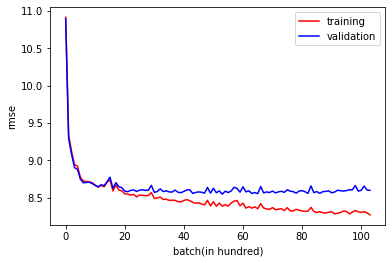

In [11]:
plot(train, valid)

validation的圖在training的上方是可以顯而易見的，因為我們是用training的data去建構模型，自然會比較貼近training的data，所以rmse會較低，而validation的rmse會較高，然而我從上方印出的validation的rmse看出，似乎在最後從8.55左右又上升至8.6左右，這就有可能是因為最後overfitting training的data的結果。

在epoch 25 時 ,batch大概在10000左右 early stop

In [12]:
test_loss = model.test(X_test, Y_test)
print(f'Test rmse {test_loss:7.4f}')

Test rmse  8.8167


Q3 (10%)
重複上題步驟，使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

In [13]:
model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 90, 0, 0, 0.00001, 0, 0, 0)

In [14]:
train, valid = model.train()

Epoch   1 | Train rmse  9.7022 | Valid rmse  9.6632
Epoch   1 | Train rmse  9.0268 | Valid rmse  8.9612
Epoch   1 | Train rmse  9.0168 | Valid rmse  8.9787
Epoch   1 | Train rmse  8.8106 | Valid rmse  8.7658
Epoch   2 | Train rmse  8.8353 | Valid rmse  8.8000
Epoch   2 | Train rmse  8.7338 | Valid rmse  8.6955
Epoch   2 | Train rmse  8.6920 | Valid rmse  8.6839
Epoch   2 | Train rmse  8.7324 | Valid rmse  8.7219
Epoch   3 | Train rmse  8.6738 | Valid rmse  8.6787
Epoch   3 | Train rmse  8.6333 | Valid rmse  8.6423
Epoch   3 | Train rmse  8.6254 | Valid rmse  8.6489
Epoch   3 | Train rmse  8.6335 | Valid rmse  8.6569
Epoch   4 | Train rmse  8.7917 | Valid rmse  8.8352
Epoch   4 | Train rmse  8.5648 | Valid rmse  8.6182
Epoch   4 | Train rmse  8.5845 | Valid rmse  8.6295
Epoch   4 | Train rmse  8.5015 | Valid rmse  8.5697
Epoch   5 | Train rmse  8.4967 | Valid rmse  8.5754
Epoch   5 | Train rmse  8.5043 | Valid rmse  8.5941
Epoch   5 | Train rmse  8.5450 | Valid rmse  8.6301
Epoch   5 | 

In [15]:
test_loss = model.test(X_test, Y_test)
print(f'H = 90 =>Test rmse {test_loss:7.4f}')

H = 90 =>Test rmse  8.8115


In [16]:
model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 180, 0, 0, 0.00001, 0, 0, 0)

In [17]:
train, valid = model.train()

Epoch   1 | Train rmse  9.9244 | Valid rmse  9.8788
Epoch   1 | Train rmse  8.9942 | Valid rmse  8.9281
Epoch   1 | Train rmse  8.8297 | Valid rmse  8.7901
Epoch   1 | Train rmse  8.7993 | Valid rmse  8.7682
Epoch   2 | Train rmse  8.7494 | Valid rmse  8.7179
Epoch   2 | Train rmse  8.7087 | Valid rmse  8.6818
Epoch   2 | Train rmse  8.6565 | Valid rmse  8.6576
Epoch   2 | Train rmse  8.6074 | Valid rmse  8.6085
Epoch   3 | Train rmse  8.7328 | Valid rmse  8.7633
Epoch   3 | Train rmse  8.6191 | Valid rmse  8.6650
Epoch   3 | Train rmse  8.5311 | Valid rmse  8.5874
Epoch   3 | Train rmse  8.5266 | Valid rmse  8.5850
Epoch   4 | Train rmse  8.5310 | Valid rmse  8.6013
Epoch   4 | Train rmse  8.5827 | Valid rmse  8.6699
Epoch   4 | Train rmse  8.5161 | Valid rmse  8.6130
Epoch   4 | Train rmse  8.4205 | Valid rmse  8.5202
Epoch   5 | Train rmse  8.4746 | Valid rmse  8.5932
Epoch   5 | Train rmse  8.4453 | Valid rmse  8.5781
Epoch   5 | Train rmse  8.4781 | Valid rmse  8.6463
Epoch   5 | 

In [18]:
test_loss = model.test(X_test, Y_test)
print(f'H = 180 =>Test rmse {test_loss:7.4f}')

H = 180 =>Test rmse  8.8262


* H = 45 =>Test rmse  8.8167
* H = 90 =>Test rmse  8.8115
* H = 180 =>Test rmse  8.8262
##### 可以看出H = 90時，Test rmse最小，比起其他H值，應該選擇H = 90

Q4 (15%)
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?


In [19]:
for H in [45, 90, 180]:
    for wd in [0.1, 0.2, 0.4]:
        print(f'training with H={H}, Weight Decay={wd}')
        model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, H, 0, 0, 0.00001,0,wd, 0)
        model.train()
        test_loss = model.test(X_test, Y_test)
        print(f'H = {H}, Weight Decay={wd} =>Test rmse {test_loss:7.4f}')
        print("======================================")

training with H=45, Weight Decay=0.1
Epoch   1 | Train rmse 10.8702 | Valid rmse 10.8494
Epoch   1 | Train rmse  9.1982 | Valid rmse  9.1213
Epoch   1 | Train rmse  8.9463 | Valid rmse  8.8926
Epoch   1 | Train rmse  8.9404 | Valid rmse  8.8958
Epoch   2 | Train rmse  8.8347 | Valid rmse  8.7881
Epoch   2 | Train rmse  8.7811 | Valid rmse  8.7516
Epoch   2 | Train rmse  8.7628 | Valid rmse  8.7418
Epoch   2 | Train rmse  8.7477 | Valid rmse  8.7346
Epoch   3 | Train rmse  8.7118 | Valid rmse  8.6861
Epoch   3 | Train rmse  8.8493 | Valid rmse  8.8392
Epoch   3 | Train rmse  8.8295 | Valid rmse  8.8197
Epoch   3 | Train rmse  8.6375 | Valid rmse  8.6382
Epoch   4 | Train rmse  8.6571 | Valid rmse  8.6507
Epoch   4 | Train rmse  8.6740 | Valid rmse  8.7011
Epoch   4 | Train rmse  8.6422 | Valid rmse  8.6783
Epoch   4 | Train rmse  8.6401 | Valid rmse  8.6540
Epoch   5 | Train rmse  8.6046 | Valid rmse  8.6207
Epoch   5 | Train rmse  8.5954 | Valid rmse  8.6392
Epoch   5 | Train rmse  8.6

Epoch   5 | Train rmse  8.5718 | Valid rmse  8.6122
Epoch   5 | Train rmse  8.5626 | Valid rmse  8.6047
Epoch   6 | Train rmse  8.5809 | Valid rmse  8.6433
Epoch   6 | Train rmse  8.5915 | Valid rmse  8.6509
Epoch   6 | Train rmse  8.5693 | Valid rmse  8.6533
Epoch   6 | Train rmse  8.5305 | Valid rmse  8.5967
Epoch   6 | Train rmse  8.5743 | Valid rmse  8.6295
Epoch   7 | Train rmse  8.5991 | Valid rmse  8.6597
Epoch   7 | Train rmse  8.5535 | Valid rmse  8.6356
Epoch   7 | Train rmse  8.5597 | Valid rmse  8.6426
Epoch   7 | Train rmse  8.5270 | Valid rmse  8.6039
Epoch   8 | Train rmse  8.5001 | Valid rmse  8.5978
Epoch   8 | Train rmse  8.5467 | Valid rmse  8.6276
Epoch   8 | Train rmse  8.4970 | Valid rmse  8.5742
Epoch   8 | Train rmse  8.4922 | Valid rmse  8.5883
Epoch   9 | Train rmse  8.4837 | Valid rmse  8.6024
Epoch   9 | Train rmse  8.5970 | Valid rmse  8.7179
Epoch   9 | Train rmse  8.4723 | Valid rmse  8.5726
Epoch   9 | Train rmse  8.4724 | Valid rmse  8.5795
Epoch  10 | 

Epoch  16 | Train rmse  8.3581 | Valid rmse  8.5792
Epoch  17 | Train rmse  8.3437 | Valid rmse  8.5662
Epoch  17 | Train rmse  8.4142 | Valid rmse  8.6025
Epoch  17 | Train rmse  8.3558 | Valid rmse  8.5986
Epoch  17 | Train rmse  8.3609 | Valid rmse  8.5828
Epoch  17 | Train rmse  8.3480 | Valid rmse  8.5756
Epoch  18 | Train rmse  8.3760 | Valid rmse  8.5743
Epoch  18 | Train rmse  8.3761 | Valid rmse  8.5878
Epoch  18 | Train rmse  8.3427 | Valid rmse  8.5881
Epoch  18 | Train rmse  8.3699 | Valid rmse  8.6094
Epoch  19 | Train rmse  8.3408 | Valid rmse  8.5955
Epoch  19 | Train rmse  8.3246 | Valid rmse  8.5872
Epoch  19 | Train rmse  8.3317 | Valid rmse  8.5822
Epoch  19 | Train rmse  8.3489 | Valid rmse  8.6251
Epoch  20 | Train rmse  8.3668 | Valid rmse  8.6653
Epoch  20 | Train rmse  8.3041 | Valid rmse  8.5885
Epoch  20 | Train rmse  8.3656 | Valid rmse  8.5982
Epoch  20 | Train rmse  8.2996 | Valid rmse  8.5804
Epoch  21 | Train rmse  8.3333 | Valid rmse  8.5602
Epoch  21 | 

Epoch  14 | Train rmse  8.1627 | Valid rmse  8.5838
Epoch  15 | Train rmse  8.1257 | Valid rmse  8.6130
Epoch  15 | Train rmse  8.1155 | Valid rmse  8.5565
Epoch  15 | Train rmse  8.0948 | Valid rmse  8.5247
Epoch  15 | Train rmse  8.1233 | Valid rmse  8.5513
Epoch  16 | Train rmse  8.1953 | Valid rmse  8.6867
Epoch  16 | Train rmse  8.1020 | Valid rmse  8.5321
Epoch  16 | Train rmse  8.1247 | Valid rmse  8.5294
Epoch  16 | Train rmse  8.0902 | Valid rmse  8.5876
Epoch  17 | Train rmse  8.0829 | Valid rmse  8.5665
Epoch  17 | Train rmse  8.1648 | Valid rmse  8.6491
Epoch  17 | Train rmse  8.1462 | Valid rmse  8.5735
Epoch  17 | Train rmse  8.0989 | Valid rmse  8.6252
Epoch  17 | Train rmse  8.1351 | Valid rmse  8.5593
Epoch  18 | Train rmse  8.0533 | Valid rmse  8.5587
Epoch  18 | Train rmse  8.0426 | Valid rmse  8.5606
Epoch  18 | Train rmse  8.0504 | Valid rmse  8.6109
Epoch  18 | Train rmse  8.0243 | Valid rmse  8.5303
Epoch  19 | Train rmse  8.0582 | Valid rmse  8.6312
Epoch  19 | 

Epoch   5 | Train rmse  8.5601 | Valid rmse  8.6255
Epoch   5 | Train rmse  8.4977 | Valid rmse  8.5681
Epoch   5 | Train rmse  8.5172 | Valid rmse  8.6180
Epoch   5 | Train rmse  8.4649 | Valid rmse  8.5665
Epoch   6 | Train rmse  8.4642 | Valid rmse  8.5926
Epoch   6 | Train rmse  8.4402 | Valid rmse  8.5730
Epoch   6 | Train rmse  8.4954 | Valid rmse  8.6337
Epoch   6 | Train rmse  8.4018 | Valid rmse  8.5447
Epoch   6 | Train rmse  8.4254 | Valid rmse  8.5507
Epoch   7 | Train rmse  8.4066 | Valid rmse  8.5545
Epoch   7 | Train rmse  8.3798 | Valid rmse  8.5444
Epoch   7 | Train rmse  8.3896 | Valid rmse  8.5715
Epoch   7 | Train rmse  8.3981 | Valid rmse  8.5664
Epoch   8 | Train rmse  8.3553 | Valid rmse  8.5103
Epoch   8 | Train rmse  8.3964 | Valid rmse  8.5715
Epoch   8 | Train rmse  8.3726 | Valid rmse  8.5498
Epoch   8 | Train rmse  8.3414 | Valid rmse  8.5587
Epoch   9 | Train rmse  8.3146 | Valid rmse  8.5267
Epoch   9 | Train rmse  8.3448 | Valid rmse  8.5532
Epoch   9 | 

Epoch   2 | Train rmse  8.6744 | Valid rmse  8.6927
Epoch   3 | Train rmse  8.6291 | Valid rmse  8.6648
Epoch   3 | Train rmse  8.7143 | Valid rmse  8.7558
Epoch   3 | Train rmse  8.5799 | Valid rmse  8.6489
Epoch   3 | Train rmse  8.7117 | Valid rmse  8.7688
Epoch   4 | Train rmse  8.4908 | Valid rmse  8.5722
Epoch   4 | Train rmse  8.5148 | Valid rmse  8.6106
Epoch   4 | Train rmse  8.5243 | Valid rmse  8.6233
Epoch   4 | Train rmse  8.4465 | Valid rmse  8.5559
Epoch   5 | Train rmse  8.5517 | Valid rmse  8.6811
Epoch   5 | Train rmse  8.4106 | Valid rmse  8.5720
Epoch   5 | Train rmse  8.4014 | Valid rmse  8.5528
Epoch   5 | Train rmse  8.4115 | Valid rmse  8.5680
Epoch   6 | Train rmse  8.3377 | Valid rmse  8.5535
Epoch   6 | Train rmse  8.3219 | Valid rmse  8.5590
Epoch   6 | Train rmse  8.4174 | Valid rmse  8.6251
Epoch   6 | Train rmse  8.2748 | Valid rmse  8.5004
Epoch   6 | Train rmse  8.3450 | Valid rmse  8.5807
Epoch   7 | Train rmse  8.2393 | Valid rmse  8.5288
Epoch   7 | 

Epoch  19 | Train rmse  7.5086 | Valid rmse  8.5963
Epoch  19 | Train rmse  7.4164 | Valid rmse  8.6349
Epoch  19 | Train rmse  7.6499 | Valid rmse  8.9770
Epoch  19 | Train rmse  7.4108 | Valid rmse  8.6331
Epoch  20 | Train rmse  7.4246 | Valid rmse  8.7596
Epoch  20 | Train rmse  7.3428 | Valid rmse  8.6996
Epoch  20 | Train rmse  7.3171 | Valid rmse  8.7136
Epoch  20 | Train rmse  7.3570 | Valid rmse  8.6173
Epoch  21 | Train rmse  7.2872 | Valid rmse  8.6710
Epoch  21 | Train rmse  7.3036 | Valid rmse  8.7424
Epoch  21 | Train rmse  7.2594 | Valid rmse  8.6620
Epoch  21 | Train rmse  7.3089 | Valid rmse  8.7127
Epoch  22 | Train rmse  7.4113 | Valid rmse  8.7220
Epoch  22 | Train rmse  7.2418 | Valid rmse  8.6356
Epoch  22 | Train rmse  7.2680 | Valid rmse  8.6736
Epoch  22 | Train rmse  7.5560 | Valid rmse  8.7653
Epoch  23 | Train rmse  7.2866 | Valid rmse  8.6574
Epoch  23 | Train rmse  7.1453 | Valid rmse  8.7284
Epoch  23 | Train rmse  7.2568 | Valid rmse  8.7436
Epoch  23 | 

* H = 45, Weight Decay=0.1 =>Test rmse  8.8199
* H = 45, Weight Decay=0.2 =>Test rmse  8.8218
* H = 45, Weight Decay=0.4 =>Test rmse  8.8675
* H = 90, Weight Decay=0.1 =>Test rmse  8.8172
* H = 90, Weight Decay=0.2 =>Test rmse  8.8568
* H = 90, Weight Decay=0.4 =>Test rmse  8.8162
* H = 180, Weight Decay=0.1 =>Test rmse  8.8317
* H = 180, Weight Decay=0.2 =>Test rmse  8.8846
* H = 180, Weight Decay=0.4 =>Test rmse  8.8315

可以看出H = 90的各個Test rmse比起其他H值得小，H的選擇應為90較合理

Q5 MLP with Dropout (15%)¶
建構一個有Dropout的四層Hidden Layer的MLP。此模型由輸入層開始，第一層由90個Input Features通過線性層轉換為H個Hidden Nodes，通過ReLu Activation Function，之後對Hidden Unit Dropout，機率為0.5。後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。
令H= 90, 使用Adaptive Moment Estimation (Adam)更新參數，設Learning Rate = 0.001，無Weight Decay與Momentum，其他參數使用預設值。畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [20]:
model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 90, 0.5, 1, 0.001,0, 0, 0)
train, valid = model.train()


Epoch   1 | Train rmse  9.4763 | Valid rmse  9.4313
Epoch   1 | Train rmse  9.1249 | Valid rmse  9.0702
Epoch   1 | Train rmse  9.0479 | Valid rmse  8.9936
Epoch   1 | Train rmse  9.0155 | Valid rmse  8.9593
Epoch   2 | Train rmse  8.9589 | Valid rmse  8.9046
Epoch   2 | Train rmse  8.9160 | Valid rmse  8.8658
Epoch   2 | Train rmse  8.8743 | Valid rmse  8.8250
Epoch   2 | Train rmse  8.8550 | Valid rmse  8.8035
Epoch   3 | Train rmse  8.8351 | Valid rmse  8.7880
Epoch   3 | Train rmse  8.8582 | Valid rmse  8.8117
Epoch   3 | Train rmse  8.8385 | Valid rmse  8.7975
Epoch   3 | Train rmse  8.8275 | Valid rmse  8.7882
Epoch   4 | Train rmse  8.8143 | Valid rmse  8.7716
Epoch   4 | Train rmse  8.7931 | Valid rmse  8.7599
Epoch   4 | Train rmse  8.7773 | Valid rmse  8.7425
Epoch   4 | Train rmse  8.7766 | Valid rmse  8.7373
Epoch   5 | Train rmse  8.7958 | Valid rmse  8.7629
Epoch   5 | Train rmse  8.7458 | Valid rmse  8.7212
Epoch   5 | Train rmse  8.7495 | Valid rmse  8.7234
Epoch   5 | 

Epoch  39 | Train rmse  8.5680 | Valid rmse  8.6203
Epoch  39 | Train rmse  8.5376 | Valid rmse  8.5946
Epoch  39 | Train rmse  8.5422 | Valid rmse  8.6049
Epoch  39 | Train rmse  8.5473 | Valid rmse  8.6036
Epoch  39 | Train rmse  8.5502 | Valid rmse  8.6072
Epoch  40 | Train rmse  8.5381 | Valid rmse  8.5944
Epoch  40 | Train rmse  8.5424 | Valid rmse  8.5981
Epoch  40 | Train rmse  8.5333 | Valid rmse  8.5898
Epoch  40 | Train rmse  8.5461 | Valid rmse  8.5977
Epoch  41 | Train rmse  8.5422 | Valid rmse  8.6045
Epoch  41 | Train rmse  8.5544 | Valid rmse  8.6066
Epoch  41 | Train rmse  8.5502 | Valid rmse  8.6101
Epoch  41 | Train rmse  8.5459 | Valid rmse  8.6012
Epoch  42 | Train rmse  8.5325 | Valid rmse  8.5982
Epoch  42 | Train rmse  8.5418 | Valid rmse  8.6088
Epoch  42 | Train rmse  8.5331 | Valid rmse  8.6023
Epoch  42 | Train rmse  8.5359 | Valid rmse  8.6015
Epoch  43 | Train rmse  8.5394 | Valid rmse  8.6071
Epoch  43 | Train rmse  8.5468 | Valid rmse  8.6211
Epoch  43 | 

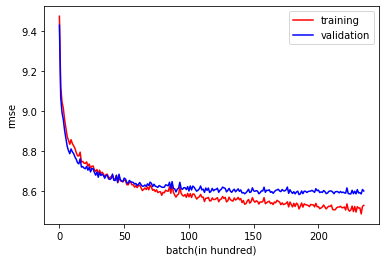

In [21]:
plot(train, valid)

validation的圖在training的上方是可以顯而易見的，因為我們是用training的data去建構模型，自然會比較貼近training的data，所以rmse會較低，而validation的rmse會較高，不過跟上一個畫圖的模型相比，這個模型的training rmse以及validation rmse相差比較不大。
在epoch 57 時 ,batch大概在24000左右 early stop

In [22]:

test_loss = model.test(X_test, Y_test)
print(f'Test rmse {test_loss:7.4f}')

Test rmse  8.7785


Q6 Explore Number of Hidden Units (10%)
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

In [23]:
for H in [20, 45, 180, 360]:
    print(f'h={H}  start training!')
    model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, H, 0.5, 1, 0.001,0, 0, 0)
    train, valid = model.train()
    test_loss = model.test(X_test, Y_test)
    print(f'H = {H} =>Test rmse {test_loss:7.4f}')
    print("======================================")


h=20  start training!
Epoch   1 | Train rmse 10.6833 | Valid rmse 10.6586
Epoch   1 | Train rmse 10.2271 | Valid rmse 10.1955
Epoch   1 | Train rmse  9.7535 | Valid rmse  9.7093
Epoch   1 | Train rmse  9.5654 | Valid rmse  9.5156
Epoch   2 | Train rmse  9.4751 | Valid rmse  9.4263
Epoch   2 | Train rmse  9.3987 | Valid rmse  9.3472
Epoch   2 | Train rmse  9.3350 | Valid rmse  9.2822
Epoch   2 | Train rmse  9.3311 | Valid rmse  9.2804
Epoch   3 | Train rmse  9.3084 | Valid rmse  9.2614
Epoch   3 | Train rmse  9.2775 | Valid rmse  9.2259
Epoch   3 | Train rmse  9.2540 | Valid rmse  9.2020
Epoch   3 | Train rmse  9.2336 | Valid rmse  9.1815
Epoch   4 | Train rmse  9.2382 | Valid rmse  9.1908
Epoch   4 | Train rmse  9.2208 | Valid rmse  9.1739
Epoch   4 | Train rmse  9.2260 | Valid rmse  9.1703
Epoch   4 | Train rmse  9.1910 | Valid rmse  9.1418
Epoch   5 | Train rmse  9.1885 | Valid rmse  9.1338
Epoch   5 | Train rmse  9.1762 | Valid rmse  9.1256
Epoch   5 | Train rmse  9.2097 | Valid rms

Epoch  13 | Train rmse  8.8260 | Valid rmse  8.7971
Epoch  13 | Train rmse  8.8316 | Valid rmse  8.7983
Epoch  13 | Train rmse  8.8079 | Valid rmse  8.7752
Epoch  14 | Train rmse  8.8133 | Valid rmse  8.7826
Epoch  14 | Train rmse  8.8060 | Valid rmse  8.7780
Epoch  14 | Train rmse  8.8238 | Valid rmse  8.7943
Epoch  14 | Train rmse  8.8128 | Valid rmse  8.7766
Epoch  15 | Train rmse  8.7994 | Valid rmse  8.7730
Epoch  15 | Train rmse  8.8034 | Valid rmse  8.7740
Epoch  15 | Train rmse  8.8019 | Valid rmse  8.7763
Epoch  15 | Train rmse  8.8107 | Valid rmse  8.7840
Epoch  16 | Train rmse  8.7935 | Valid rmse  8.7684
Epoch  16 | Train rmse  8.8018 | Valid rmse  8.7796
Epoch  16 | Train rmse  8.8152 | Valid rmse  8.7940
Epoch  16 | Train rmse  8.7910 | Valid rmse  8.7664
Epoch  17 | Train rmse  8.7998 | Valid rmse  8.7760
Epoch  17 | Train rmse  8.7796 | Valid rmse  8.7534
Epoch  17 | Train rmse  8.8013 | Valid rmse  8.7735
Epoch  17 | Train rmse  8.8091 | Valid rmse  8.7850
Epoch  17 | 

Epoch   2 | Train rmse  8.8080 | Valid rmse  8.7673
Epoch   2 | Train rmse  8.8088 | Valid rmse  8.7760
Epoch   3 | Train rmse  8.7468 | Valid rmse  8.7214
Epoch   3 | Train rmse  8.7385 | Valid rmse  8.7155
Epoch   3 | Train rmse  8.7288 | Valid rmse  8.7046
Epoch   3 | Train rmse  8.7328 | Valid rmse  8.7137
Epoch   4 | Train rmse  8.7020 | Valid rmse  8.6840
Epoch   4 | Train rmse  8.6994 | Valid rmse  8.6863
Epoch   4 | Train rmse  8.7018 | Valid rmse  8.6889
Epoch   4 | Train rmse  8.6808 | Valid rmse  8.6790
Epoch   5 | Train rmse  8.6638 | Valid rmse  8.6592
Epoch   5 | Train rmse  8.6681 | Valid rmse  8.6647
Epoch   5 | Train rmse  8.6430 | Valid rmse  8.6461
Epoch   5 | Train rmse  8.6605 | Valid rmse  8.6629
Epoch   6 | Train rmse  8.6656 | Valid rmse  8.6661
Epoch   6 | Train rmse  8.6625 | Valid rmse  8.6669
Epoch   6 | Train rmse  8.6359 | Valid rmse  8.6458
Epoch   6 | Train rmse  8.6269 | Valid rmse  8.6470
Epoch   6 | Train rmse  8.6429 | Valid rmse  8.6482
Epoch   7 | 

Epoch   1 | Train rmse  9.1717 | Valid rmse  9.1237
Epoch   1 | Train rmse  8.9991 | Valid rmse  8.9517
Epoch   1 | Train rmse  8.9019 | Valid rmse  8.8654
Epoch   1 | Train rmse  8.8827 | Valid rmse  8.8432
Epoch   2 | Train rmse  8.8256 | Valid rmse  8.7943
Epoch   2 | Train rmse  8.7728 | Valid rmse  8.7377
Epoch   2 | Train rmse  8.7886 | Valid rmse  8.7633
Epoch   2 | Train rmse  8.7434 | Valid rmse  8.7138
Epoch   3 | Train rmse  8.7342 | Valid rmse  8.7141
Epoch   3 | Train rmse  8.6796 | Valid rmse  8.6659
Epoch   3 | Train rmse  8.7110 | Valid rmse  8.6942
Epoch   3 | Train rmse  8.6658 | Valid rmse  8.6524
Epoch   4 | Train rmse  8.6401 | Valid rmse  8.6352
Epoch   4 | Train rmse  8.6168 | Valid rmse  8.6156
Epoch   4 | Train rmse  8.6158 | Valid rmse  8.6229
Epoch   4 | Train rmse  8.5909 | Valid rmse  8.5965
Epoch   5 | Train rmse  8.6102 | Valid rmse  8.6242
Epoch   5 | Train rmse  8.6093 | Valid rmse  8.6326
Epoch   5 | Train rmse  8.5948 | Valid rmse  8.6197
Epoch   5 | 

Epoch  39 | Train rmse  8.0096 | Valid rmse  8.4300
Epoch  39 | Train rmse  7.9862 | Valid rmse  8.4296
Epoch  39 | Train rmse  8.0358 | Valid rmse  8.4411
Epoch  39 | Train rmse  7.9776 | Valid rmse  8.4140
Epoch  39 | Train rmse  8.0710 | Valid rmse  8.4559
Epoch  40 | Train rmse  8.0099 | Valid rmse  8.4416
Epoch  40 | Train rmse  7.9829 | Valid rmse  8.4249
Epoch  40 | Train rmse  7.9986 | Valid rmse  8.4366
Epoch  40 | Train rmse  8.0291 | Valid rmse  8.4507
Epoch  41 | Train rmse  8.0306 | Valid rmse  8.4525
Epoch  41 | Train rmse  7.9803 | Valid rmse  8.4254
Epoch  41 | Train rmse  7.9834 | Valid rmse  8.4234
Epoch  41 | Train rmse  8.0145 | Valid rmse  8.4358
Epoch  42 | Train rmse  7.9897 | Valid rmse  8.4344
Epoch  42 | Train rmse  8.0288 | Valid rmse  8.4337
Epoch  42 | Train rmse  7.9677 | Valid rmse  8.4237
Epoch  42 | Train rmse  8.0151 | Valid rmse  8.4439
Epoch  43 | Train rmse  8.0343 | Valid rmse  8.4495
Epoch  43 | Train rmse  7.9735 | Valid rmse  8.4256
Epoch  43 | 

Epoch  76 | Train rmse  7.8519 | Valid rmse  8.4032
Epoch  77 | Train rmse  7.8093 | Valid rmse  8.3940
Epoch  77 | Train rmse  7.7668 | Valid rmse  8.3827
Epoch  77 | Train rmse  7.7729 | Valid rmse  8.3858
Epoch  77 | Train rmse  7.8330 | Valid rmse  8.4051
Epoch  78 | Train rmse  7.8426 | Valid rmse  8.4229
Epoch  78 | Train rmse  7.9776 | Valid rmse  8.4815
Epoch  78 | Train rmse  7.7765 | Valid rmse  8.3861
Epoch  78 | Train rmse  7.8063 | Valid rmse  8.4022
Epoch  78 | Train rmse  7.8577 | Valid rmse  8.4148
Epoch  79 | Train rmse  7.8166 | Valid rmse  8.4023
Epoch  79 | Train rmse  7.8134 | Valid rmse  8.3959
Epoch  79 | Train rmse  7.7723 | Valid rmse  8.3769
Epoch  79 | Train rmse  7.8444 | Valid rmse  8.4102
Epoch  80 | Train rmse  7.7615 | Valid rmse  8.3752
Epoch  80 | Train rmse  7.8631 | Valid rmse  8.4249
Epoch  80 | Train rmse  7.7845 | Valid rmse  8.4015
Epoch  80 | Train rmse  7.7749 | Valid rmse  8.3942
Epoch  81 | Train rmse  7.8671 | Valid rmse  8.4255
Epoch  81 | 

* H = 20 =>Test rmse  9.1397
* H = 45 =>Test rmse  8.8644
* H = 180 =>Test rmse  8.7406
* H = 360 =>Test rmse  8.7790

可以看出 H = 180，Test rmse =8.7406，為其中最低的Test rmse



#### Q7 L2 + L1 Loss (15%)
我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [24]:
model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 90, 0.5, 1, 0.001,0, 0, 1, 0.5)
train, valid = model.train()
    

Epoch   1 | Train rmse  9.4942 | Valid rmse  9.4471
Epoch   1 | Train rmse  9.1517 | Valid rmse  9.0988
Epoch   1 | Train rmse  9.0732 | Valid rmse  9.0191
Epoch   1 | Train rmse  9.0088 | Valid rmse  8.9562
Epoch   2 | Train rmse  8.9521 | Valid rmse  8.8988
Epoch   2 | Train rmse  8.9526 | Valid rmse  8.9035
Epoch   2 | Train rmse  8.9137 | Valid rmse  8.8634
Epoch   2 | Train rmse  8.8756 | Valid rmse  8.8252
Epoch   3 | Train rmse  8.8551 | Valid rmse  8.8053
Epoch   3 | Train rmse  8.8432 | Valid rmse  8.7986
Epoch   3 | Train rmse  8.8072 | Valid rmse  8.7582
Epoch   3 | Train rmse  8.8108 | Valid rmse  8.7619
Epoch   4 | Train rmse  8.8271 | Valid rmse  8.7849
Epoch   4 | Train rmse  8.7694 | Valid rmse  8.7261
Epoch   4 | Train rmse  8.7755 | Valid rmse  8.7383
Epoch   4 | Train rmse  8.7975 | Valid rmse  8.7614
Epoch   5 | Train rmse  8.7692 | Valid rmse  8.7301
Epoch   5 | Train rmse  8.7474 | Valid rmse  8.7123
Epoch   5 | Train rmse  8.7643 | Valid rmse  8.7349
Epoch   5 | 

Epoch  39 | Train rmse  8.5291 | Valid rmse  8.6023
Epoch  39 | Train rmse  8.5406 | Valid rmse  8.6002
Epoch  39 | Train rmse  8.5198 | Valid rmse  8.5891
Epoch  39 | Train rmse  8.5251 | Valid rmse  8.5901
Epoch  39 | Train rmse  8.5363 | Valid rmse  8.5999
Epoch  40 | Train rmse  8.5224 | Valid rmse  8.5940
Epoch  40 | Train rmse  8.5252 | Valid rmse  8.5879
Epoch  40 | Train rmse  8.5112 | Valid rmse  8.5839
Epoch  40 | Train rmse  8.5384 | Valid rmse  8.5927
Epoch  41 | Train rmse  8.5362 | Valid rmse  8.5902
Epoch  41 | Train rmse  8.5354 | Valid rmse  8.5952
Epoch  41 | Train rmse  8.5300 | Valid rmse  8.5887
Epoch  41 | Train rmse  8.5285 | Valid rmse  8.5861
Epoch  42 | Train rmse  8.5201 | Valid rmse  8.5871
Epoch  42 | Train rmse  8.5154 | Valid rmse  8.5917
Epoch  42 | Train rmse  8.5091 | Valid rmse  8.5799
Epoch  42 | Train rmse  8.5088 | Valid rmse  8.5848
Epoch  43 | Train rmse  8.5287 | Valid rmse  8.5921
Epoch  43 | Train rmse  8.5288 | Valid rmse  8.5915
Epoch  43 | 

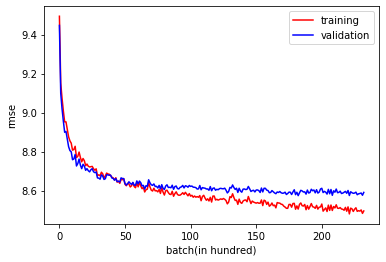

In [25]:
plot(train, valid)

validation的圖在training的上方是可以顯而易見的，因為我們是用training的data去建構模型，自然會比較貼近training的data，所以rmse會較低，而validation的rmse會較高，不過跟第一個畫圖的模型相比，這個模型的training rmse以及validation rmse相差比較不大。 在epoch 56 時 ,batch大概在23000左右 early stop,rmse的下降差不多在batch5000左右開始趨緩

In [26]:
test_loss = model.test(X_test, Y_test)
print(f'Test rmse {test_loss:7.4f}')

Test rmse  8.7503


In [27]:
for z in [0.0, 0.1, 0.5, 0.9, 1]:
    print(f'z={z}  start training!')
    model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 90, 0.5, 1, 0.001,0, 0, 1, z)
    model.train()
    test_loss = model.test(X_test, Y_test)
    print(f'z={z}=>Test rmse {test_loss:7.4f}')
    print("======================================")
  

z=0.0  start training!
Epoch   1 | Train rmse 10.5757 | Valid rmse 10.5521
Epoch   1 | Train rmse 10.1024 | Valid rmse 10.0720
Epoch   1 | Train rmse  9.5355 | Valid rmse  9.4987
Epoch   1 | Train rmse  9.2965 | Valid rmse  9.2460
Epoch   2 | Train rmse  9.3082 | Valid rmse  9.2638
Epoch   2 | Train rmse  9.2424 | Valid rmse  9.1956
Epoch   2 | Train rmse  9.1838 | Valid rmse  9.1392
Epoch   2 | Train rmse  9.0990 | Valid rmse  9.0493
Epoch   3 | Train rmse  9.1443 | Valid rmse  9.0982
Epoch   3 | Train rmse  9.1386 | Valid rmse  9.0994
Epoch   3 | Train rmse  9.1716 | Valid rmse  9.1294
Epoch   3 | Train rmse  9.0927 | Valid rmse  9.0575
Epoch   4 | Train rmse  9.1060 | Valid rmse  9.0708
Epoch   4 | Train rmse  9.0656 | Valid rmse  9.0304
Epoch   4 | Train rmse  9.0636 | Valid rmse  9.0274
Epoch   4 | Train rmse  9.0561 | Valid rmse  9.0193
Epoch   5 | Train rmse  9.0021 | Valid rmse  8.9708
Epoch   5 | Train rmse  9.0303 | Valid rmse  8.9916
Epoch   5 | Train rmse  9.0085 | Valid rm

Epoch  39 | Train rmse  8.8553 | Valid rmse  8.8733
Epoch  39 | Train rmse  8.8695 | Valid rmse  8.8838
Epoch  39 | Train rmse  8.8667 | Valid rmse  8.8918
Epoch  39 | Train rmse  8.8707 | Valid rmse  8.8921
Epoch  39 | Train rmse  8.8625 | Valid rmse  8.8762
Epoch  40 | Train rmse  8.8248 | Valid rmse  8.8458
Epoch  40 | Train rmse  8.8138 | Valid rmse  8.8350
Epoch  40 | Train rmse  8.8307 | Valid rmse  8.8466
Epoch  40 | Train rmse  8.8469 | Valid rmse  8.8623
Epoch  41 | Train rmse  8.8473 | Valid rmse  8.8614
Epoch  41 | Train rmse  8.8367 | Valid rmse  8.8502
Epoch  41 | Train rmse  8.8564 | Valid rmse  8.8784
Epoch  41 | Train rmse  8.8567 | Valid rmse  8.8786
Epoch  42 | Train rmse  8.8172 | Valid rmse  8.8356
Epoch  42 | Train rmse  8.8691 | Valid rmse  8.8891
Epoch  42 | Train rmse  8.8505 | Valid rmse  8.8684
Epoch  42 | Train rmse  8.8757 | Valid rmse  8.8971
Epoch  43 | Train rmse  8.8349 | Valid rmse  8.8579
Epoch  43 | Train rmse  8.8640 | Valid rmse  8.8939
Epoch  43 | 

Epoch  14 | Train rmse  8.6773 | Valid rmse  8.6836
Epoch  14 | Train rmse  8.6312 | Valid rmse  8.6385
Epoch  14 | Train rmse  8.6293 | Valid rmse  8.6341
Epoch  14 | Train rmse  8.6548 | Valid rmse  8.6615
Epoch  15 | Train rmse  8.6436 | Valid rmse  8.6528
Epoch  15 | Train rmse  8.6296 | Valid rmse  8.6379
Epoch  15 | Train rmse  8.6441 | Valid rmse  8.6519
Epoch  15 | Train rmse  8.6571 | Valid rmse  8.6594
Epoch  16 | Train rmse  8.6325 | Valid rmse  8.6391
Epoch  16 | Train rmse  8.6305 | Valid rmse  8.6442
Epoch  16 | Train rmse  8.6168 | Valid rmse  8.6243
Epoch  16 | Train rmse  8.6500 | Valid rmse  8.6619
Epoch  17 | Train rmse  8.6298 | Valid rmse  8.6401
Epoch  17 | Train rmse  8.6251 | Valid rmse  8.6370
Epoch  17 | Train rmse  8.6062 | Valid rmse  8.6253
Epoch  17 | Train rmse  8.6388 | Valid rmse  8.6495
Epoch  17 | Train rmse  8.6238 | Valid rmse  8.6376
Epoch  18 | Train rmse  8.6106 | Valid rmse  8.6288
Epoch  18 | Train rmse  8.6255 | Valid rmse  8.6402
Epoch  18 | 

Epoch  51 | Train rmse  8.5422 | Valid rmse  8.6035
Epoch  52 | Train rmse  8.5333 | Valid rmse  8.5980
Epoch  52 | Train rmse  8.5456 | Valid rmse  8.6048
Epoch  52 | Train rmse  8.5365 | Valid rmse  8.6005
Epoch  52 | Train rmse  8.5456 | Valid rmse  8.6091
Epoch  53 | Train rmse  8.5268 | Valid rmse  8.5916
Epoch  53 | Train rmse  8.5383 | Valid rmse  8.6034
Epoch  53 | Train rmse  8.5499 | Valid rmse  8.6081
Epoch  53 | Train rmse  8.5469 | Valid rmse  8.6104
Epoch  54 | Train rmse  8.5182 | Valid rmse  8.5941
Epoch  54 | Train rmse  8.5349 | Valid rmse  8.6051
Epoch  54 | Train rmse  8.5402 | Valid rmse  8.6106
Epoch  54 | Train rmse  8.5298 | Valid rmse  8.5955
Epoch  55 | Train rmse  8.5273 | Valid rmse  8.5938
Epoch  55 | Train rmse  8.5301 | Valid rmse  8.5946
Epoch  55 | Train rmse  8.5347 | Valid rmse  8.6047
Epoch  55 | Train rmse  8.5407 | Valid rmse  8.6064
Epoch  56 | Train rmse  8.5558 | Valid rmse  8.6194
Epoch  56 | Train rmse  8.5395 | Valid rmse  8.6062
Epoch  56 | 

Epoch  17 | Train rmse  8.6173 | Valid rmse  8.6481
Epoch  17 | Train rmse  8.6411 | Valid rmse  8.6664
Epoch  17 | Train rmse  8.5986 | Valid rmse  8.6283
Epoch  17 | Train rmse  8.6389 | Valid rmse  8.6659
Epoch  18 | Train rmse  8.6082 | Valid rmse  8.6451
Epoch  18 | Train rmse  8.6244 | Valid rmse  8.6540
Epoch  18 | Train rmse  8.6233 | Valid rmse  8.6505
Epoch  18 | Train rmse  8.6069 | Valid rmse  8.6344
Epoch  19 | Train rmse  8.5968 | Valid rmse  8.6283
Epoch  19 | Train rmse  8.5966 | Valid rmse  8.6281
Epoch  19 | Train rmse  8.5910 | Valid rmse  8.6237
Epoch  19 | Train rmse  8.5925 | Valid rmse  8.6214
Epoch  20 | Train rmse  8.5783 | Valid rmse  8.6161
Epoch  20 | Train rmse  8.5842 | Valid rmse  8.6214
Epoch  20 | Train rmse  8.5892 | Valid rmse  8.6271
Epoch  20 | Train rmse  8.5819 | Valid rmse  8.6201
Epoch  21 | Train rmse  8.5794 | Valid rmse  8.6190
Epoch  21 | Train rmse  8.6093 | Valid rmse  8.6430
Epoch  21 | Train rmse  8.5906 | Valid rmse  8.6321
Epoch  21 | 

Epoch  55 | Train rmse  8.5212 | Valid rmse  8.6029
Epoch  55 | Train rmse  8.5072 | Valid rmse  8.5895
Epoch  55 | Train rmse  8.4985 | Valid rmse  8.5952
Epoch  55 | Train rmse  8.4882 | Valid rmse  8.5790
Epoch  56 | Train rmse  8.4895 | Valid rmse  8.5856
Epoch  56 | Train rmse  8.5066 | Valid rmse  8.5913
Epoch  56 | Train rmse  8.5126 | Valid rmse  8.5887
Epoch  56 | Train rmse  8.4976 | Valid rmse  8.5787
Epoch  56 | Train rmse  8.5072 | Valid rmse  8.5803
Epoch  57 | Train rmse  8.5089 | Valid rmse  8.5847
Epoch  57 | Train rmse  8.4898 | Valid rmse  8.5789
Epoch  57 | Train rmse  8.5018 | Valid rmse  8.5825
Epoch  57 | Train rmse  8.4941 | Valid rmse  8.5835
Over 5000!!!
z=0.5=>Test rmse  8.7522
z=0.9  start training!
Epoch   1 | Train rmse  9.4921 | Valid rmse  9.4489
Epoch   1 | Train rmse  9.1618 | Valid rmse  9.1022
Epoch   1 | Train rmse  9.0717 | Valid rmse  9.0144
Epoch   1 | Train rmse  9.0013 | Valid rmse  8.9468
Epoch   2 | Train rmse  8.9431 | Valid rmse  8.8867
Epo

Epoch  35 | Train rmse  8.5568 | Valid rmse  8.6151
Epoch  35 | Train rmse  8.5436 | Valid rmse  8.6129
Epoch  35 | Train rmse  8.5525 | Valid rmse  8.6176
Epoch  36 | Train rmse  8.5441 | Valid rmse  8.6102
Epoch  36 | Train rmse  8.5413 | Valid rmse  8.6056
Epoch  36 | Train rmse  8.5585 | Valid rmse  8.6155
Epoch  36 | Train rmse  8.5383 | Valid rmse  8.6106
Epoch  37 | Train rmse  8.5407 | Valid rmse  8.6133
Epoch  37 | Train rmse  8.5450 | Valid rmse  8.6136
Epoch  37 | Train rmse  8.5511 | Valid rmse  8.6176
Epoch  37 | Train rmse  8.5408 | Valid rmse  8.6108
Epoch  38 | Train rmse  8.5610 | Valid rmse  8.6223
Epoch  38 | Train rmse  8.5377 | Valid rmse  8.6035
Epoch  38 | Train rmse  8.5438 | Valid rmse  8.6072
Epoch  38 | Train rmse  8.5719 | Valid rmse  8.6277
Epoch  39 | Train rmse  8.5377 | Valid rmse  8.5996
Epoch  39 | Train rmse  8.5294 | Valid rmse  8.5989
Epoch  39 | Train rmse  8.5261 | Valid rmse  8.6022
Epoch  39 | Train rmse  8.5336 | Valid rmse  8.6020
Epoch  39 | 

Epoch   1 | Train rmse  9.0707 | Valid rmse  9.0165
Epoch   1 | Train rmse  9.0212 | Valid rmse  8.9702
Epoch   2 | Train rmse  8.9437 | Valid rmse  8.8910
Epoch   2 | Train rmse  8.9283 | Valid rmse  8.8785
Epoch   2 | Train rmse  8.8951 | Valid rmse  8.8504
Epoch   2 | Train rmse  8.8885 | Valid rmse  8.8458
Epoch   3 | Train rmse  8.8588 | Valid rmse  8.8216
Epoch   3 | Train rmse  8.8463 | Valid rmse  8.8045
Epoch   3 | Train rmse  8.8783 | Valid rmse  8.8412
Epoch   3 | Train rmse  8.8222 | Valid rmse  8.7891
Epoch   4 | Train rmse  8.8127 | Valid rmse  8.7761
Epoch   4 | Train rmse  8.8051 | Valid rmse  8.7666
Epoch   4 | Train rmse  8.8201 | Valid rmse  8.7924
Epoch   4 | Train rmse  8.7784 | Valid rmse  8.7499
Epoch   5 | Train rmse  8.7662 | Valid rmse  8.7392
Epoch   5 | Train rmse  8.7562 | Valid rmse  8.7272
Epoch   5 | Train rmse  8.7576 | Valid rmse  8.7353
Epoch   5 | Train rmse  8.7571 | Valid rmse  8.7347
Epoch   6 | Train rmse  8.7355 | Valid rmse  8.7141
Epoch   6 | 

Epoch  39 | Train rmse  8.5440 | Valid rmse  8.6089
Epoch  39 | Train rmse  8.5563 | Valid rmse  8.6136
Epoch  39 | Train rmse  8.5369 | Valid rmse  8.5943
Epoch  40 | Train rmse  8.5477 | Valid rmse  8.6071
Epoch  40 | Train rmse  8.5401 | Valid rmse  8.6009
Epoch  40 | Train rmse  8.5264 | Valid rmse  8.5869
Epoch  40 | Train rmse  8.5357 | Valid rmse  8.6017
Epoch  41 | Train rmse  8.5401 | Valid rmse  8.5932
Epoch  41 | Train rmse  8.5305 | Valid rmse  8.5891
Epoch  41 | Train rmse  8.5475 | Valid rmse  8.6053
Epoch  41 | Train rmse  8.5415 | Valid rmse  8.6094
Epoch  42 | Train rmse  8.5413 | Valid rmse  8.6126
Epoch  42 | Train rmse  8.5225 | Valid rmse  8.5900
Epoch  42 | Train rmse  8.5264 | Valid rmse  8.5915
Epoch  42 | Train rmse  8.5265 | Valid rmse  8.5890
Epoch  43 | Train rmse  8.5210 | Valid rmse  8.5882
Epoch  43 | Train rmse  8.5303 | Valid rmse  8.6031
Epoch  43 | Train rmse  8.5383 | Valid rmse  8.5995
Epoch  43 | Train rmse  8.5223 | Valid rmse  8.5887
Epoch  44 | 

* z=0.0 => Test rmse  8.9712
* z=0.1 => Test rmse  8.7773
* z=0.5 => Test rmse  8.7522
* z=0.9 => Test rmse  8.7597
* z=1.0 => Test rmse  8.7735

可以看出z在0.5時，Test rmse=8.7522，為其中最低的。


#### Q8 L2 + Customerized Loss (15%)
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [28]:
model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 90, 0.5, 1, 0.001,0, 0, 2, 0)
train, valid = model.train()

Epoch   1 | Train rmse 10.5915 | Valid rmse 10.5678
Epoch   1 | Train rmse  9.6974 | Valid rmse  9.6681
Epoch   1 | Train rmse  9.4236 | Valid rmse  9.3888
Epoch   1 | Train rmse  9.3271 | Valid rmse  9.2860
Epoch   2 | Train rmse  9.3177 | Valid rmse  9.2814
Epoch   2 | Train rmse  9.1914 | Valid rmse  9.1525
Epoch   2 | Train rmse  9.2622 | Valid rmse  9.2255
Epoch   2 | Train rmse  9.2486 | Valid rmse  9.2111
Epoch   3 | Train rmse  9.1767 | Valid rmse  9.1324
Epoch   3 | Train rmse  9.1380 | Valid rmse  9.0921
Epoch   3 | Train rmse  9.1202 | Valid rmse  9.0780
Epoch   3 | Train rmse  9.1180 | Valid rmse  9.0771
Epoch   4 | Train rmse  9.1081 | Valid rmse  9.0707
Epoch   4 | Train rmse  9.0670 | Valid rmse  9.0331
Epoch   4 | Train rmse  9.1072 | Valid rmse  9.0793
Epoch   4 | Train rmse  9.0962 | Valid rmse  9.0629
Epoch   5 | Train rmse  9.0749 | Valid rmse  9.0373
Epoch   5 | Train rmse  9.0694 | Valid rmse  9.0357
Epoch   5 | Train rmse  9.0329 | Valid rmse  9.0006
Epoch   5 | 

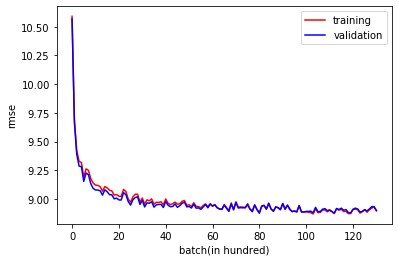

In [29]:
plot(train, valid)

In [30]:
test_loss = model.test(X_test, Y_test)
print(f'Test rmse {test_loss:7.4f}')

Test rmse  8.9733


validation的圖與training的幾乎重疊，這個模型的training rmse以及validation rmse幾乎沒有相差多少，可以知道這個模型對於validation表現相當成功。 在epoch 32 時 ,batch大概在13000左右 early stop

In [31]:
for z in [0.0, 0.1, 0.5, 0.9, 1]:
    print(f'z={z}  start training!')
    model = my_model(X_subtrain, Y_subtrain, X_valid, Y_valid, 90, 0.5, 1, 0.001,0, 0, 2, z)
    model.train()
    test_loss = model.test(X_test, Y_test)
    print(f'z={z}=>Test rmse {test_loss:7.4f}')
    print("======================================")


z=0.0  start training!
Epoch   1 | Train rmse 10.6055 | Valid rmse 10.5779
Epoch   1 | Train rmse  9.7560 | Valid rmse  9.7257
Epoch   1 | Train rmse  9.4283 | Valid rmse  9.3858
Epoch   1 | Train rmse  9.3244 | Valid rmse  9.2776
Epoch   2 | Train rmse  9.2805 | Valid rmse  9.2319
Epoch   2 | Train rmse  9.2411 | Valid rmse  9.1963
Epoch   2 | Train rmse  9.2065 | Valid rmse  9.1583
Epoch   2 | Train rmse  9.1957 | Valid rmse  9.1460
Epoch   3 | Train rmse  9.1903 | Valid rmse  9.1501
Epoch   3 | Train rmse  9.1243 | Valid rmse  9.0788
Epoch   3 | Train rmse  9.1218 | Valid rmse  9.0759
Epoch   3 | Train rmse  9.1315 | Valid rmse  9.0838
Epoch   4 | Train rmse  9.0652 | Valid rmse  9.0165
Epoch   4 | Train rmse  9.0475 | Valid rmse  9.0092
Epoch   4 | Train rmse  9.0788 | Valid rmse  9.0406
Epoch   4 | Train rmse  9.0447 | Valid rmse  9.0059
Epoch   5 | Train rmse  9.0634 | Valid rmse  9.0265
Epoch   5 | Train rmse  9.0503 | Valid rmse  9.0147
Epoch   5 | Train rmse  9.0662 | Valid rm

Epoch  17 | Train rmse  8.6280 | Valid rmse  8.6420
Epoch  17 | Train rmse  8.6160 | Valid rmse  8.6303
Epoch  17 | Train rmse  8.5991 | Valid rmse  8.6190
Epoch  17 | Train rmse  8.6023 | Valid rmse  8.6130
Epoch  17 | Train rmse  8.6013 | Valid rmse  8.6148
Epoch  18 | Train rmse  8.6129 | Valid rmse  8.6311
Epoch  18 | Train rmse  8.6138 | Valid rmse  8.6325
Epoch  18 | Train rmse  8.5974 | Valid rmse  8.6196
Epoch  18 | Train rmse  8.5886 | Valid rmse  8.6028
Epoch  19 | Train rmse  8.6040 | Valid rmse  8.6263
Epoch  19 | Train rmse  8.6053 | Valid rmse  8.6299
Epoch  19 | Train rmse  8.6229 | Valid rmse  8.6410
Epoch  19 | Train rmse  8.5946 | Valid rmse  8.6157
Epoch  20 | Train rmse  8.5873 | Valid rmse  8.6053
Epoch  20 | Train rmse  8.5957 | Valid rmse  8.6193
Epoch  20 | Train rmse  8.6007 | Valid rmse  8.6257
Epoch  20 | Train rmse  8.5873 | Valid rmse  8.6118
Epoch  21 | Train rmse  8.5937 | Valid rmse  8.6177
Epoch  21 | Train rmse  8.5750 | Valid rmse  8.5988
Epoch  21 | 

Epoch  54 | Train rmse  8.5012 | Valid rmse  8.5801
Epoch  55 | Train rmse  8.5301 | Valid rmse  8.6102
Epoch  55 | Train rmse  8.5139 | Valid rmse  8.5938
Epoch  55 | Train rmse  8.5004 | Valid rmse  8.5888
Epoch  55 | Train rmse  8.5090 | Valid rmse  8.5964
Epoch  56 | Train rmse  8.5226 | Valid rmse  8.6022
Epoch  56 | Train rmse  8.5102 | Valid rmse  8.5919
Epoch  56 | Train rmse  8.5003 | Valid rmse  8.5800
Epoch  56 | Train rmse  8.5057 | Valid rmse  8.5823
Epoch  56 | Train rmse  8.5402 | Valid rmse  8.6118
Epoch  57 | Train rmse  8.4991 | Valid rmse  8.5799
Epoch  57 | Train rmse  8.5159 | Valid rmse  8.5943
Epoch  57 | Train rmse  8.4956 | Valid rmse  8.5753
Epoch  57 | Train rmse  8.4971 | Valid rmse  8.5779
Over 5000!!!
z=0.1=>Test rmse  8.7666
z=0.5  start training!
Epoch   1 | Train rmse  9.5228 | Valid rmse  9.4791
Epoch   1 | Train rmse  9.1735 | Valid rmse  9.1216
Epoch   1 | Train rmse  9.1077 | Valid rmse  9.0514
Epoch   1 | Train rmse  9.0257 | Valid rmse  8.9681
Epo

Epoch  35 | Train rmse  8.5295 | Valid rmse  8.5942
Epoch  35 | Train rmse  8.5726 | Valid rmse  8.6292
Epoch  35 | Train rmse  8.5519 | Valid rmse  8.6116
Epoch  35 | Train rmse  8.5473 | Valid rmse  8.6060
Epoch  36 | Train rmse  8.5466 | Valid rmse  8.6034
Epoch  36 | Train rmse  8.5517 | Valid rmse  8.6101
Epoch  36 | Train rmse  8.5268 | Valid rmse  8.5970
Epoch  36 | Train rmse  8.5483 | Valid rmse  8.6134
Epoch  37 | Train rmse  8.5359 | Valid rmse  8.6002
Epoch  37 | Train rmse  8.5904 | Valid rmse  8.6414
Epoch  37 | Train rmse  8.5430 | Valid rmse  8.6056
Epoch  37 | Train rmse  8.5451 | Valid rmse  8.6082
Epoch  38 | Train rmse  8.5545 | Valid rmse  8.6195
Epoch  38 | Train rmse  8.5285 | Valid rmse  8.5958
Epoch  38 | Train rmse  8.5293 | Valid rmse  8.5933
Epoch  38 | Train rmse  8.5369 | Valid rmse  8.5985
Epoch  39 | Train rmse  8.5241 | Valid rmse  8.5866
Epoch  39 | Train rmse  8.5338 | Valid rmse  8.5978
Epoch  39 | Train rmse  8.5505 | Valid rmse  8.6106
Epoch  39 | 

Epoch   4 | Train rmse  8.7784 | Valid rmse  8.7406
Epoch   4 | Train rmse  8.7954 | Valid rmse  8.7553
Epoch   4 | Train rmse  8.7792 | Valid rmse  8.7494
Epoch   5 | Train rmse  8.7951 | Valid rmse  8.7647
Epoch   5 | Train rmse  8.7511 | Valid rmse  8.7171
Epoch   5 | Train rmse  8.7461 | Valid rmse  8.7172
Epoch   5 | Train rmse  8.7422 | Valid rmse  8.7144
Epoch   6 | Train rmse  8.7516 | Valid rmse  8.7255
Epoch   6 | Train rmse  8.7339 | Valid rmse  8.7045
Epoch   6 | Train rmse  8.7216 | Valid rmse  8.6920
Epoch   6 | Train rmse  8.7191 | Valid rmse  8.6917
Epoch   6 | Train rmse  8.7077 | Valid rmse  8.6801
Epoch   7 | Train rmse  8.7010 | Valid rmse  8.6847
Epoch   7 | Train rmse  8.7066 | Valid rmse  8.6896
Epoch   7 | Train rmse  8.6887 | Valid rmse  8.6745
Epoch   7 | Train rmse  8.6783 | Valid rmse  8.6673
Epoch   8 | Train rmse  8.7088 | Valid rmse  8.6887
Epoch   8 | Train rmse  8.6867 | Valid rmse  8.6694
Epoch   8 | Train rmse  8.6829 | Valid rmse  8.6706
Epoch   8 | 

Epoch  42 | Train rmse  8.5204 | Valid rmse  8.5904
Epoch  42 | Train rmse  8.5129 | Valid rmse  8.5744
Epoch  42 | Train rmse  8.5186 | Valid rmse  8.5825
Epoch  42 | Train rmse  8.5195 | Valid rmse  8.5925
Epoch  43 | Train rmse  8.5284 | Valid rmse  8.5870
Epoch  43 | Train rmse  8.5272 | Valid rmse  8.5864
Epoch  43 | Train rmse  8.5398 | Valid rmse  8.6027
Epoch  43 | Train rmse  8.5411 | Valid rmse  8.6147
Epoch  44 | Train rmse  8.5284 | Valid rmse  8.6028
Epoch  44 | Train rmse  8.5356 | Valid rmse  8.6081
Epoch  44 | Train rmse  8.5380 | Valid rmse  8.6112
Epoch  44 | Train rmse  8.5326 | Valid rmse  8.6039
Epoch  45 | Train rmse  8.5046 | Valid rmse  8.5847
Epoch  45 | Train rmse  8.5079 | Valid rmse  8.5877
Epoch  45 | Train rmse  8.5213 | Valid rmse  8.5977
Epoch  45 | Train rmse  8.5185 | Valid rmse  8.5894
Epoch  45 | Train rmse  8.5320 | Valid rmse  8.6010
Epoch  46 | Train rmse  8.5171 | Valid rmse  8.5941
Epoch  46 | Train rmse  8.5351 | Valid rmse  8.6071
Epoch  46 | 

Epoch  17 | Train rmse  8.6095 | Valid rmse  8.6400
Epoch  17 | Train rmse  8.5956 | Valid rmse  8.6330
Epoch  17 | Train rmse  8.6090 | Valid rmse  8.6414
Epoch  18 | Train rmse  8.5951 | Valid rmse  8.6338
Epoch  18 | Train rmse  8.6054 | Valid rmse  8.6387
Epoch  18 | Train rmse  8.6209 | Valid rmse  8.6578
Epoch  18 | Train rmse  8.6118 | Valid rmse  8.6462
Epoch  19 | Train rmse  8.5993 | Valid rmse  8.6342
Epoch  19 | Train rmse  8.5977 | Valid rmse  8.6300
Epoch  19 | Train rmse  8.6018 | Valid rmse  8.6370
Epoch  19 | Train rmse  8.5752 | Valid rmse  8.6144
Epoch  20 | Train rmse  8.6072 | Valid rmse  8.6432
Epoch  20 | Train rmse  8.5804 | Valid rmse  8.6159
Epoch  20 | Train rmse  8.5865 | Valid rmse  8.6215
Epoch  20 | Train rmse  8.5941 | Valid rmse  8.6232
Epoch  21 | Train rmse  8.5838 | Valid rmse  8.6256
Epoch  21 | Train rmse  8.6122 | Valid rmse  8.6420
Epoch  21 | Train rmse  8.5728 | Valid rmse  8.6130
Epoch  21 | Train rmse  8.5978 | Valid rmse  8.6348
Epoch  22 | 

Epoch  55 | Train rmse  8.5098 | Valid rmse  8.5933
Epoch  55 | Train rmse  8.4958 | Valid rmse  8.5871
Epoch  55 | Train rmse  8.5039 | Valid rmse  8.5835
Epoch  56 | Train rmse  8.5001 | Valid rmse  8.5881
Epoch  56 | Train rmse  8.4954 | Valid rmse  8.5858
Epoch  56 | Train rmse  8.4995 | Valid rmse  8.5880
Epoch  56 | Train rmse  8.4808 | Valid rmse  8.5762
Epoch  56 | Train rmse  8.5006 | Valid rmse  8.5888
Epoch  57 | Train rmse  8.5000 | Valid rmse  8.5875
Epoch  57 | Train rmse  8.5007 | Valid rmse  8.5857
Epoch  57 | Train rmse  8.4771 | Valid rmse  8.5703
Epoch  57 | Train rmse  8.5031 | Valid rmse  8.5896
Epoch  58 | Train rmse  8.5308 | Valid rmse  8.6062
Epoch  58 | Train rmse  8.5125 | Valid rmse  8.5926
Epoch  58 | Train rmse  8.5060 | Valid rmse  8.5947
Epoch  58 | Train rmse  8.4899 | Valid rmse  8.5818
Epoch  59 | Train rmse  8.4943 | Valid rmse  8.5851
Epoch  59 | Train rmse  8.5027 | Valid rmse  8.5930
Epoch  59 | Train rmse  8.5144 | Valid rmse  8.5948
Epoch  59 | 

* z=0.0=>Test rmse  8.9755
* z=0.1=>Test rmse  8.7666
* z=0.5=>Test rmse  8.7609
* z=0.9=>Test rmse  8.7807
* z=1.0=>Test rmse  8.7693

可以看出z=0.5時，Test rmse = 8.7609，為其中最低的。